In [7]:
using LinearAlgebra
using StaticArrays
using Pkg
using PyCall
using Plots
#using PyPlot
using Distances
using Statistics
theme(:dark)
# ENV["PYTHON"]="/usr/local/Caskroom/miniconda/base/bin/python"
# Pkg.build("PyCall")
p = pyimport("pymatgen")


PyObject <module 'pymatgen' from '/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/pymatgen/__init__.py'>

In [2]:

struct tetra
    ge::Array{Float64,1}
    cl1::Array{Float64,1}
    cl2::Array{Float64,1}
    cl3::Array{Float64,1}
end

In [3]:
icross(b) = copy(Transpose(hcat([cross(Matrix(1.0I, 3, 3)[:,i],b) for i in 1:3]...)));
anchor(tetra) = (tetra.ge+tetra.cl1+tetra.cl2+tetra.cl3)/4
function Mdot(a1,a2)
    #=redefing dot product like numpy for matrix=#
    a1_1=copy(Transpose(a1))'
    return [dot(a1_1[i,:],a2) for i in 1:3]
end
function rot(coords,anc,axis,theta)
    #=rotate coords by theta wrt anc with axis as axis=#
    theta %= 2 * pi
    rm=exp(icross(axis/norm(axis))*theta)
    val=Mdot(rm,(coords-anc))+anc
    return val
    end;

In [4]:
function rot_tetra_test_1(t::tetra,axis::Array{Float64,1},theta)
    #=rotate all atoms in tetra by theta with axis = axis=#
    anc=anchor(t)
    ge=rot(t.ge,anc,axis,theta)
    cl1=rot(t.cl1,anc,axis,theta)
    cl2=rot(t.cl2,anc,axis,theta)
    cl3=rot(t.cl3,anc,axis,theta)
    return tetra(ge,cl1,cl2,cl3)
    end;

In [5]:
@time begin
n=4
system=Array{tetra,3}(undef,n,n,n);
for i in 1:length(system)
    system[i]=tetra(randn(3),randn(3),randn(3),randn(3))
    end;


axis=[0,1,1.]
theta=pi/2
for i in 1:length(system)
    system[i]=rot_tetra_test_1(system[i],axis,theta)
end
    
end

  2.951308 seconds (9.24 M allocations: 440.247 MiB, 6.52% gc time)


In [8]:
function get_nn_1(system,pos,size)
    #= Get first 6 Nearest neibghors to Ge atoms which are Chlorine with PBC=#
    a=(-system[1,1,1].ge+system[1,1,2].ge)[3]
#     pbc(i,n) = i%n > 0 ? i%n : n
    function pbc(i,n) 
        if i>n
            return i-n,a*size
        elseif i<=0
            return n,-a*(size-1)
        else 
            return i,0
        end
    end
    tmp=Array{Float64, 1}[]
    for i in -1:1
        for j in -1:1
            for k in -1:1
                i1,ai=pbc(pos[1]+i,size)
                j1,aj=pbc(pos[2]+j,size)
                k1,ak=pbc(pos[3]+k,size)
#                 println("$i1 $j1 $k1")
                push!(tmp,system[i1,j1,k1].cl1+[ai,aj,ak])
                push!(tmp,system[i1,j1,k1].cl2+[ai,aj,ak])
                push!(tmp,system[i1,j1,k1].cl3+[ai,aj,ak])
            end
        end
    end
    return tmp
end

get_nn_1 (generic function with 1 method)

In [9]:
function get_mean_var(system,pos,return_type="var")
    # Get the mean or variance of a position of lattice  wrt bond distance#
    sys=system[pos[1],pos[2],pos[3]]
    distance_1=colwise(Euclidean(), sys.ge, copy(hcat(get_nn_1(system,pos,size(system)[1])...)))
    nn=sort(distance_1)[1:6]
    var_sys=var(nn)
    mean_sys=mean(nn)
    if return_type=="mean"
        return mean_sys
    else
        return var_sys
    end
end

get_mean_var (generic function with 2 methods)

In [219]:

a=(-system[1,1,1].ge+system[1,1,2].ge)[3]
euclidean((system[end,end,end].cl1-[a*(n-1),a*(n-1),a*(n-1)]),system[1,1,1].ge)
#(system[end,end,end].cl3-[a*(n-1),a*(n-1),a*(n-1)])
#system[1,1,1].ge
euclidean((system[1,1,1].cl1),system[1,1,1].ge)

2.7906784747365916

In [15]:
 function make_symstem(n=2)
    cssii2=p.Structure.from_file("Cssii2.cif")
    struc1=cssii2.copy()
    struc1.make_supercell([[n,0,0],[0,n,0],[0,0,n]])
    dist=cssii2.get_distance(1,3)+.1
    positions=Array{Int64, 1}[]
    for i in struc1
        if i.species_string=="Si"
            push!(positions,struc1.get_neighbor_list(dist,[i])[2])
        end
    end
    system=Array{tetra,3}(undef,n,n,n);
    cnt=1
    for i in 1:n
        for j in 1:n
            for k in 1:n
                ge=get(struc1,reverse(positions[cnt])[1]).coords
                cl1=get(struc1,reverse(positions[cnt])[2]).coords
                cl2=get(struc1,reverse(positions[cnt])[3]).coords
                cl3=get(struc1,reverse(positions[cnt])[4]).coords
                system[i,j,k]=tetra(ge,cl1,cl2,cl3)    
                cnt+=1
            end
        end
    end
    return system
end

make_symstem (generic function with 2 methods)

In [13]:
@time begin
n=4
system=make_symstem(n);
println("done\n")
end

done

  2.803999 seconds (2.73 M allocations: 139.905 MiB, 3.21% gc time)


In [14]:
mean([get_mean_var(system,[i,j,k],"var") for i in 1:n for j in 1:n for k in 1:n])

0.03171667069694222

## Plotting and checking stuff

In [19]:
a=[]
nk=20
@time begin
for i in LinRange(0, pi*2, nk)
        for j in LinRange(0, pi*2, nk)
theta=i
axis=[2,2,2.]
system_test=copy(system)
pos_1=[4,4,4]
system_test[pos_1[1],pos_1[3],pos_1[3]]=
        rot_tetra_test_1(system[pos_1[1],pos_1[3],pos_1[3]],axis,theta);
theta=j
axis=[1,0,0.]
system_test[pos_1[1],pos_1[3],pos_1[3]]=
        rot_tetra_test_1(system_test[pos_1[1],pos_1[3],pos_1[3]],axis,theta);
            
mean_1=mean([get_mean_var(system_test,[i,j,k],"var") for i in 1:n for j in 1:n for k in 1:n])
push!(a,mean_1)
end
end
end

  1.964861 seconds (15.83 M allocations: 1.435 GiB, 25.70% gc time)


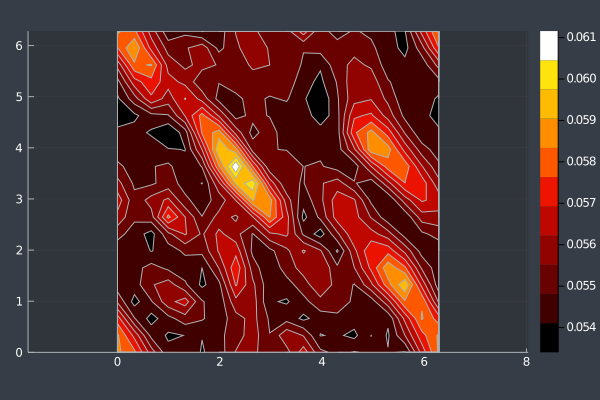

In [20]:
a=reshape(a,nk,nk)
contourf(LinRange(0, pi*2, nk),
    LinRange(0, pi*2, nk), a,levels=10,aspect_ratio = 1)

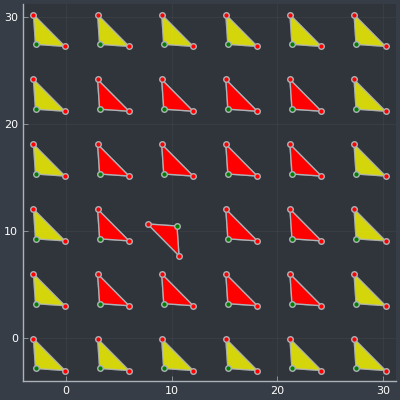

In [135]:
system_test=copy(system)


plot()
pos_1=[2,2,1]
axis=[0,0,1.]
theta=pi/1
system_test[pos_1[1],pos_1[2],pos_1[3]]=
        rot_tetra_test_1(system[pos_1[1],pos_1[2],pos_1[3]],axis,theta);
for i in 0:n+1
    for j in 0:n+1
        a=(-system[1,1,1].ge+system[1,1,2].ge)[3]
        function pbc(i,n) 
            if i>n
                return i-n,a*n
            elseif i<=0
                return n,-a*(n)
            else 
                return i,0
            end
        end
        i1,ai=pbc(i,n)
        j1,aj=pbc(j,n)
    x=[]
    y=[]
    if ai!=0 || aj !=0
            col="yellow";alpha=0.8
    else 
            col="red";alpha=1
    end
    x=[system_test[i1,j1,1].ge[1]+ai
            ,system_test[i1,j1,1].cl1[1]+ai
            ,system_test[i1,j1,1].cl2[1]+ai
            ,system_test[i1,j1,1].ge[1]+ai]
        
    y=[system_test[i1,j1,1].ge[2]+aj
            ,system_test[i1,j1,1].cl1[2]+aj
            ,system_test[i1,j1,1].cl2[2]+aj
            ,system_test[i1,j1,1].ge[2]+aj]
    plt=plot!(x,y,color="grey",label="")
    plot!(Plots.Shape(x,y),label="",color=col,alpha=alpha)
    scatter!(plt,x[2:3],y[2:3],color="red",label="")
    scatter!(plt,[x[1]],[y[1]],color="green",label="")
    end
end
plot!(size=(400,400))

In [148]:
system_test=copy(system)
function plot_perov()
    plt=plot(5,xlim=(-6,33),ylim=(-6,33), aspect_ratio=1,legend=false,size = (800, 800))
    global system_test
    pos_1=[rand(1:4),rand(1:4),1]
    axis=[0,0,1.]
    theta=pi*2*rand()
    system_test[pos_1[1],pos_1[2],pos_1[3]]=
            rot_tetra_test_1(system[pos_1[1],pos_1[2],pos_1[3]],axis,theta);
    for i in 0:n+1
    for j in 0:n+1
        a=(-system[1,1,1].ge+system[1,1,2].ge)[3]
        function pbc(i,n) 
            if i>n
                return i-n,a*n
            elseif i<=0
                return n,-a*(n)
            else 
                return i,0
            end
        end
        i1,ai=pbc(i,n)
        j1,aj=pbc(j,n)
    x=[]
    y=[]
    if ai!=0 || aj !=0
            col="yellow";alpha=0.8
    else 
            col="red";alpha=1
    end
    x=[system_test[i1,j1,1].ge[1]+ai
            ,system_test[i1,j1,1].cl1[1]+ai
            ,system_test[i1,j1,1].cl2[1]+ai
            ,system_test[i1,j1,1].ge[1]+ai]
        
    y=[system_test[i1,j1,1].ge[2]+aj
            ,system_test[i1,j1,1].cl1[2]+aj
            ,system_test[i1,j1,1].cl2[2]+aj
            ,system_test[i1,j1,1].ge[2]+aj]
    plt=plot!(x,y,color="grey",label="")
    plot!(Plots.Shape(x,y),label="",color=col,alpha=alpha)
    scatter!(plt,x[2:3],y[2:3],color="red",label="")
    scatter!(plt,[x[1]],[y[1]],color="green",label="")
    end
end
end

plot_perov (generic function with 2 methods)

In [ ]:
anim = @animate for i ∈ 1:200
    plot_perov()
end
gif(anim, "peorvsk2.gif", fps = 2)

4

In [16]:
Plots.plotlyjs()
function plot_tetra(pos1,pl)
    scatter!(pl,[pos1[i][1] for i in [2,3,4]],
        [pos1[i][2] for i in [2,3,4]],
        [pos1[i][3] for i in [2,3,4]],color="blue",label="")
    scatter!(pl,[pos1[i][1] for i in [1]],
        [pos1[i][2] for i in [1]],
        [pos1[i][3] for i in [1]],color="red",label="")
    for i in 2:4
        plot!(pl,[pos1[1][1],pos1[i][1]],
            [pos1[1][2],pos1[i][2]],
            [pos1[1][3],pos1[i][3]],linewidth=3,color="black",label="")
    plot!(pl,[pos1[i][1] for i in [2,3,4,2]],
            [pos1[i][2] for i in [2,3,4,2]],
            [pos1[i][3] for i in [2,3,4,2]],linewidth=3,
            color="grey",linestyle=:dashdot,label="")
    end
end

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-8357247541921885076\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-9514486180850799231\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-8357247541921885076\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

plot_tetra (generic function with 1 method)

In [ ]:
pos1=[[0.510337, 0.75    , 0.891894],
       [0.398849, 0.507524, 0.695264],
       [0.398849, 0.992476, 0.695264],
       [0.912641, 0.75    , 0.901359]]

pos2=[[0.456659, 0.25    , 0.386263],
       [0.345171, 0.007524, 0.199633],
       [0.345171, 0.492476, 0.199633],
       [0.858963, 0.25    , 0.395728]]
lat=[5.91437, 7.19642, 8.36143]
pl1=plot(ticks = false)
pos1_cart=[pos1[i] .* lat for i in 1:4]
pos2_cart=[pos2[i] .* lat for i in 1:4]
plot_tetra(pos1_cart,pl1)
plot_tetra(pos2_cart,pl1)
display(pl1)

### 3D plot the system and tetras

In [425]:
Plots.plotlyjs()
function plot_tetra(tetra::tetra,pl)
    pos1=[tetra.ge,tetra.cl1,tetra.cl2,tetra.cl3]
    scatter!(pl,[pos1[i][1] for i in [2,3,4]],
        [pos1[i][2] for i in [2,3,4]],
        [pos1[i][3] for i in [2,3,4]],color="darkblue",label="")
    scatter!(pl,[pos1[i][1] for i in [1]],
        [pos1[i][2] for i in [1]],
        [pos1[i][3] for i in [1]],color="darkred",label="")
    for i in 2:4
        plot!(pl,[pos1[1][1],pos1[i][1]],
            [pos1[1][2],pos1[i][2]],
            [pos1[1][3],pos1[i][3]],linewidth=5,color="white",label="")
    plot!(pl,[pos1[i][1] for i in [2,3,4,2]],
            [pos1[i][2] for i in [2,3,4,2]],
            [pos1[i][3] for i in [2,3,4,2]],linewidth=5,
            color="grey",linestyle=:dash,label="")
    end
end

plot_tetra (generic function with 2 methods)

In [ ]:
pl1=plot(ticks = false)
system_test=copy(system)
pos_1=[rand(1:4),rand(1:4),1]
    axis=[0,0,1.]
    theta=pi
    system_test[pos_1[1],pos_1[2],pos_1[3]]=
            rot_tetra_test_1(system[pos_1[1],pos_1[2],pos_1[3]],axis,theta);


for i in system_test
    plot_tetra(i,pl1)
end
plot!(pl1,size=(900,900))
display(pl1)

In [13]:
function get_dipol_vec(tetra::tetra)
    return (tetra.ge - (tetra.cl1+tetra.cl2+tetra.cl3)/3)/norm(tetra.ge - (tetra.cl1+tetra.cl2+tetra.cl3)/3)
end
# Check 
test_1=system[1,1,1];
norm(get_dipol_vec(test_1))

0.9999999999999999

In [14]:
function get_dipole_dist(tetra1::tetra,tetra2::tetra,pl=nothing)
    r1=(tetra1.ge +tetra1.cl1+tetra1.cl2+tetra1.cl3)/4
    r2=(tetra2.ge +tetra2.cl1+tetra2.cl2+tetra2.cl3)/4
    if pl == nothing
        return r1-r2
    else
        plot_tetra(tetra1,pl)
        plot_tetra(tetra2,pl)
        plot!(pl,[i[1] for i in [r1,r2]],[i[2] for i in [r1,r2]],[i[3] for i in [r1,r2]],color="red",linewidth=3,label="connecting vector r12")
        end;
    end;

In [ ]:
test1=system[1,1,1];
test2=system[1,2,2];
pl=plot()
get_dipole_dist(test1,test2,pl)
display(pl)

In [21]:
r12=get_dipole_dist(test1,test2)
d1=get_dipol_vec(test1)
d2=get_dipol_vec(test2)


3-element Array{Float64,1}:
 -0.5770239610076693
 -0.5532537562435473
 -0.6007941657717937

In [15]:
function get_dipole_energy_between_tetra(tetra1::tetra,tetra2::tetra)
    r12=get_dipole_dist(tetra1,tetra2)*1.0E-10
    d1=get_dipol_vec(tetra1)*1.0E-10
    d2=get_dipol_vec(tetra2)*1.0E-10
    four_pe0= 9 * 10^9 #1/4πe0 in N⋅m^2⋅C^−2
    return ( dot(d1,d2) - 3*(dot(d1,r12)*dot(d2,r12))/norm(r12)^2 ) * four_pe0 * norm(r12)^-3
    end;

In [16]:
get_dipole_energy_between_tetra(system[1,1,1],system[2,2,1])

1.2859680259718412e19

In [10]:
function get_dipole_energy(system,pos)
    a=(-system[1,1,1].ge+system[1,1,2].ge)[3]
    lat=size(system)[1]
    function pbc(i,n) 
        if i>n
            return i-n,a*(lat+)
        elseif i<=0
            return n,-a*(lat)
        else 
            return i,0
        end
    end
    dipole_energy=0
    nn=[[0,0,1],[0,1,0],[1,0,0],[0,0,-1],[0,-1,0],[-1,0,0]]
    for i in nn
        i1,ai=pbc(pos[1]+i[1],lat)
        j1,aj=pbc(pos[2]+i[2],lat)
        k1,ak=pbc(pos[3]+i[3],lat)
        if [i1,j1,k1] != pos
            ge=system[i1,j1,k1].ge+[ai,aj,ak]
            cl1=system[i1,j1,k1].cl1+[ai,aj,ak]
            cl2=system[i1,j1,k1].cl2+[ai,aj,ak]
            cl3=system[i1,j1,k1].cl3+[ai,aj,ak]
            tetra_pbc=tetra(ge,cl1,cl2,cl3)
            dipole_energy+=get_dipole_energy_between_tetra(
                system[pos[1],pos[2],pos[3]]
                ,tetra_pbc)
            end;
        end;
    return dipole_energy
    end;

LoadError: syntax: unexpected ")"

# Check this code and the one above

In [ ]:
@time begin
a=[]
for i in 1:4
    for j in 1:4
        for k in 1:4
            push!(a,get_dipole_energy(system,[i,j,k]))
            end;end;end;
end
histogram(a)

In [346]:
get_dipole_energy(system,[2,2,2])

1637.75

In [347]:
get_dipole_energy(system,[2,2,3])

149.875

# NN plotting to verify

In [8]:
function pbc_1(system,index)
    eval_1(i,n)= ((abs(i)-1) ÷ n)*((sign(i)+1) ÷ 2) - ((sign(i-1)-1) ÷ 2)*((i-n) ÷ n)
    index_1(i,n)=((abs(i+n-1) % n)+1)
    unit_size=size(system)[1]
    a=(-system[1,1,1].ge+system[1,1,2].ge)[3]*unit_size
    uc=eval_1.(index,unit_size)*a
    index_mod=index_1.(index,unit_size)#index .% (unit_size+1)
    return index_mod,uc
    end;

In [9]:
function system_at_index(system,index)
    index_mod,uc=pbc_1(system,index)
    tetra_tmp=system[index_mod[1],index_mod[2],index_mod[3]]
    ge=tetra_tmp.ge+uc
    cl1=tetra_tmp.cl1+uc
    cl2=tetra_tmp.cl2+uc
    cl3=tetra_tmp.cl3+uc
    return tetra(ge,cl1,cl2,cl3)
    end;


In [18]:
function get_nn_2(system,pos)
    tmp=Array{Float64, 1}[]
    for i in -1:1
        for j in -1:1
            for k in -1:1
                index_tmp=pos+[i,j,k]
                temp=system_at_index(system,index_tmp)
                push!(tmp,temp.cl1)
                push!(tmp,temp.cl2)
                push!(tmp,temp.cl3)
            end
        end
    end
    return tmp
end
function get_mean_var(system,pos,return_type="var")
    # Get the mean or variance of a position of lattice  wrt bond distance#
    sys=system[pos[1],pos[2],pos[3]]
    distance_1=colwise(Euclidean(), sys.ge, copy(hcat(get_nn_2(system,pos)...)))
    nn=sort(distance_1)[1:6]
    var_sys=var(nn)
    mean_sys=mean(nn)
    if return_type=="mean"
        return mean_sys
    else
        return var_sys
    end
end
get_mean_var(system,[3,3,2])

0.03719145135120818

In [ ]:
Plots.plotlyjs()
function plot_tetra(tetra::tetra,pl)
    pos1=[tetra.ge,tetra.cl1,tetra.cl2,tetra.cl3]
    scatter!(pl,[pos1[i][1] for i in [2,3,4]],
        [pos1[i][2] for i in [2,3,4]],
        [pos1[i][3] for i in [2,3,4]],color="darkblue",label="")
    scatter!(pl,[pos1[i][1] for i in [1]],
        [pos1[i][2] for i in [1]],
        [pos1[i][3] for i in [1]],color="darkred",label="")
    for i in 2:4
        plot!(pl,[pos1[1][1],pos1[i][1]],
            [pos1[1][2],pos1[i][2]],
            [pos1[1][3],pos1[i][3]],linewidth=5,color="white",label="")
    plot!(pl,[pos1[i][1] for i in [2,3,4,2]],
            [pos1[i][2] for i in [2,3,4,2]],
            [pos1[i][3] for i in [2,3,4,2]],linewidth=5,
            color="grey",linestyle=:dash,label="")
    end
end
index=[1,1,1]
pl=plot()
for i in [[0,0,1],[0,0,-1],[0,1,0],[0,-1,0],[1,0,0],[-1,0,0]]
    index_tmp=index+i
    plot_tetra(system_at_index(system,index_tmp),pl)
    end;
plot_tetra(system[index[1],index[2],index[3]],pl)
display(pl)

In [26]:
function get_dipole_energy_between_tetra(tetra1::tetra,tetra2::tetra)
    r12=get_dipole_dist(tetra1,tetra2)#*1.0E-10
    d1=get_dipol_vec(tetra1)#*1.0E-10
    d2=get_dipol_vec(tetra2)#*1.0E-10
    four_pe0= 9 * 10^9 #1/4πe0 in N⋅m^2⋅C^−2
    return BigFloat(( dot(d1,d2) - 3*(dot(d1,r12)*dot(d2,r12))/norm(r12)^2 ) * four_pe0 * norm(r12)^-3)
    end;

In [27]:
get_dipole_energy_between_tetra(system[1,1,1],system[1,1,2])

-1.95231463768437671661376953125e+09

In [28]:
get_dipole_energy_between_tetra(system[1,1,2],system[1,1,3])

3.28697970436811161041259765625e+09

In [2]:
#= Defining structure for tetra
=#
struct tetra
    ge::Array{Float64,1}
    cl1::Array{Float64,1}
    cl2::Array{Float64,1}
    cl3::Array{Float64,1}
end
#check equavality of two struc 
function check_equal(t1::tetra,t2::tetra)
    if t1.ge==t2.ge && t1.cl1==t2.cl1  && t1.cl2==t2.cl2 && t1.cl3==t2.cl3
        return true
    else
        return false
        end;
    end;
#=------------------
Plotting Tools
-------------------=#
function plot_tetra(tetra::tetra,pl)
    lw=2
    pos1=[tetra.ge,tetra.cl1,tetra.cl2,tetra.cl3]
    scatter!(pl,[pos1[i][1] for i in [2,3,4]],
        [pos1[i][2] for i in [2,3,4]],
        [pos1[i][3] for i in [2,3,4]],color="darkblue",label="")
    scatter!(pl,[pos1[i][1] for i in [1]],
        [pos1[i][2] for i in [1]],
        [pos1[i][3] for i in [1]],color="darkred",label="")
    for i in 2:4
        plot!(pl,[pos1[1][1],pos1[i][1]],
            [pos1[1][2],pos1[i][2]],
            [pos1[1][3],pos1[i][3]],linewidth=lw,color="white",label="")
    plot!(pl,[pos1[i][1] for i in [2,3,4,2]],
            [pos1[i][2] for i in [2,3,4,2]],
            [pos1[i][3] for i in [2,3,4,2]],linewidth=lw,
            color="grey",linestyle=:dash,label="")
    end
end

plot_tetra (generic function with 1 method)

In [11]:
#= Mat mul for rotation
=#
icross(b) = copy(Transpose(hcat([cross(Matrix(1.0I, 3, 3)[:,i],b) for i in 1:3]...)));
anchor(tetra) = (tetra.ge+tetra.cl1+tetra.cl2+tetra.cl3)/4

function Mdot(a1,a2)
    #=redefing dot product like numpy for matrix=#
    a1_1=copy(Transpose(a1))'
    return [dot(a1_1[i,:],a2) for i in 1:3]
end


function rot(coords,anc,axis,theta)
    #=rotate coords by theta wrt anc with axis as axis=#
    theta %= 2 * pi
    rm=exp(icross(axis/norm(axis))*theta)
    val=Mdot(rm,(coords-anc))+anc
    return val
    end;


#ROtating a tetra
function rot_tetra_test_1(t::tetra,axis::Array{Float64,1},theta)
    #=rotate all atoms in tetra by theta with axis = axis=#
    anc=anchor(t)
    ge=rot(t.ge,anc,axis,theta)
    cl1=rot(t.cl1,anc,axis,theta)
    cl2=rot(t.cl2,anc,axis,theta)
    cl3=rot(t.cl3,anc,axis,theta)
    return tetra(ge,cl1,cl2,cl3)
    end;

#---PBC index
function pbc_1(system,index)
    eval_1(i,n)= ((abs(i)-1) ÷ n)*((sign(i)+1) ÷ 2) - ((sign(i-1)-1) ÷ 2)*((i-n) ÷ n)
    index_1(i,n)=((abs(i+n-1) % n)+1)
    unit_size=size(system)[1]
    a=(-system[1,1,1].ge+system[1,1,2].ge)[3]*unit_size
    uc=eval_1.(index,unit_size)*a
    index_mod=index_1.(index,unit_size)#index .% (unit_size+1)
    return index_mod,uc
    end;

#----get the tetra of a system at given index with PBC
function system_at_index(system,index)
    index_mod,uc=pbc_1(system,index)
    tetra_tmp=system[index_mod[1],index_mod[2],index_mod[3]]
    ge=[round(i,digits=4) for i in tetra_tmp.ge+uc]
    cl1=[round(i,digits=4) for i in tetra_tmp.cl1+uc]
    cl2=[round(i,digits=4) for i in tetra_tmp.cl2+uc]
    cl3=[round(i,digits=4) for i in tetra_tmp.cl3+uc]
    return tetra(ge,cl1,cl2,cl3)
    end;




# NN algorithm
function get_nn_2(system,pos)
    tmp=Array{Float64, 1}[]
    for i in -1:1
        for j in -1:1
            for k in -1:1
                index_tmp=pos+[i,j,k]
                temp=system_at_index(system,index_tmp)
                push!(tmp,temp.cl1)
                push!(tmp,temp.cl2)
                push!(tmp,temp.cl3)
            end
        end
    end
    return tmp
end

# Mean and Var from NN
function get_mean_var(system,pos,return_type="var")
    # Get the mean or variance of a position of lattice  wrt bond distance#
    sys=system[pos[1],pos[2],pos[3]]
    distance_1=colwise(Euclidean(), sys.ge, copy(hcat(get_nn_2(system,pos)...)))
    nn=sort(distance_1)[1:6]
    var_sys=var(nn)
    mean_sys=mean(nn)
    if return_type=="mean"
        return mean_sys
    else
        return var_sys
    end
end


# Make the system from CsSiI2.cif and pymatgen

function make_symstem(n=2)
    cssii2=p.Structure.from_file("Cssii2.cif")
    struc1=cssii2.copy()
    struc1.make_supercell([[n,0,0],[0,n,0],[0,0,n]])
    dist=cssii2.get_distance(1,3)+.1
    positions=Array{Int64, 1}[]
    for i in struc1
        if i.species_string=="Si"
            push!(positions,struc1.get_neighbor_list(dist,[i])[2])
        end
    end
    system=Array{tetra,3}(undef,n,n,n);
    cnt=1
    for i in 1:n
        for j in 1:n
            for k in 1:n
                ge=[round(i,digits=4) for i in get(struc1,reverse(positions[cnt])[1]).coords]
                cl1=[round(i,digits=4) for i in get(struc1,reverse(positions[cnt])[2]).coords]
                cl2=[round(i,digits=4) for i in get(struc1,reverse(positions[cnt])[3]).coords]
                cl3=[round(i,digits=4) for i in get(struc1,reverse(positions[cnt])[4]).coords]
                system[i,j,k]=tetra(ge,cl1,cl2,cl3)    
                cnt+=1
            end
        end
    end
    return system
end

# Function to get dipole orientation of a tetrahedron

function get_dipol_vec(tetra::tetra)
    return (tetra.ge - (tetra.cl1+tetra.cl2+tetra.cl3)/3)/norm(tetra.ge - (tetra.cl1+tetra.cl2+tetra.cl3)/3)
end

# Get the distance  vector between two tetrahedrons supplying pl will plot it in pl
function get_dipole_dist(tetra1::tetra,tetra2::tetra,pl=nothing)
    r1=(tetra1.ge +tetra1.cl1+tetra1.cl2+tetra1.cl3)/4
    r2=(tetra2.ge +tetra2.cl1+tetra2.cl2+tetra2.cl3)/4
    if pl == nothing
        return r1-r2
    else
        plot_tetra(tetra1,pl)
        plot_tetra(tetra2,pl)
        plot!(pl,[i[1] for i in [r1,r2]],[i[2] for i in [r1,r2]],[i[3] for i in [r1,r2]],color="red",linewidth=3,label="connecting vector r12")
        end;
    end;

#=--- dipole energy between two tetra hedrons
BigFloat is needed for accuracy. Been struggling for ages without that ! sigh. =#

function get_dipole_energy_between_tetra(tetra1::tetra,tetra2::tetra)
    r12=[BigFloat(i) for i in get_dipole_dist(tetra1,tetra2)]*1.0E-10
    d1=[BigFloat(i) for i in get_dipol_vec(tetra1)]*1.0E-10
    d2=[BigFloat(i) for i in get_dipol_vec(tetra2)]*1.0E-10
    four_pe0= 9 * 10^9 #1/4πe0 in N⋅m^2⋅C^−2
    return BigFloat(( dot(d1,d2) - 3*(dot(d1,r12)*dot(d2,r12))/norm(r12)^2 ) * four_pe0 * norm(r12)^-3)
    end;

#= Get dipole energy of a given system at pos
Need to check the other algorithm giving weired results=#
function get_dipole_energy(system,pos)
    #=
    To calculate NN distnce, but it is nn_dist=[6.067,8.58,10.508,12.134,13.566,14.861,17.16,18.201,21.017]
    n=3
    unique(sort(round.(vec([norm(get_dipole_dist(system[1,1,1],system[i,j,k])) for i in 1:1+n, j in 1:1+n, k in 1:1+n]),digits=3)))=#
    nn_dist=[6.067,8.58,10.508,12.134,13.566,14.861,17.16,18.201,21.017]
    NN=1 # NN to consider for ewald sum
    dipole_energy=[]
    tetra_origin=system_at_index(system,pos)
    nn=[[0,0,1],[0,1,0],[1,0,0],[0,0,-1],[0,-1,0],[-1,0,0]]
    for i in -2:2
        for j in -1:1
            for k in -1:1
                index_tmp=pos+[i,j,k]
                temp=system_at_index(system,index_tmp)
                if 0<3#norm(get_dipole_dist(temp,tetra_origin))<=nn_dist[NN]+.3
                    if ! check_equal(temp,tetra_origin)
                        tmp=get_dipole_energy_between_tetra(
                                        tetra_origin
                                            ,temp)
                        push!(dipole_energy,tmp)
                            end;
                    end;
                end;
            end;
        end;
#     for i in nn
#         index_tmp=pos+i
#         temp=system_at_index(system,index_tmp)
#         if ! check_equal(temp,tetra_origin)
#             tmp=get_dipole_energy_between_tetra(
#                             tetra_origin
#                                 ,temp)
#             push!(dipole_energy,tmp)
#             #print("$index_tmp $pos $tmp\n")
#             end;
#         end;
    return sum(dipole_energy)
end;



In [ ]:
function get_dipole_energy_between_tetra(tetra1::tetra,tetra2::tetra)
    r12=[BigFloat(i) for i in get_dipole_dist(tetra1,tetra2)]#*1.0E-10
    d1=[BigFloat(i) for i in get_dipol_vec(tetra1)]#*1.0E-10
    d2=[BigFloat(i) for i in get_dipol_vec(tetra2)]#*1.0E-10
    four_pe0= 1#9 * 10^9 #1/4πe0 in N⋅m^2⋅C^−2
    return BigFloat(( dot(d1,d2) - 3*(dot(d1,r12)*dot(d2,r12))/norm(r12)^2 ) * four_pe0 * norm(r12)^-3)
    end;
n=4;nk=300;
system=make_symstem(n);
a=[]
b=[]
c=[]
for i in LinRange(0,2*pi,nk)
    system_test1=copy(system)
    system_test2=copy(system)
    theta=i
    axis=[1,1,1.]
    pos_1=[2,2,2]
    system_test1[pos_1[1],pos_1[2],pos_1[3]]=
                rot_tetra_test_1(system_at_index(system,pos_1),axis,theta);
    pos_2=[2,3,2]
    system_test2[pos_2[1],pos_2[2],pos_2[3]]=
                rot_tetra_test_1(system_at_index(system,pos_2),axis,theta);
    push!(c,get_dipole_energy(system_test1,pos_1)-get_dipole_energy(system_test2,pos_2))
    push!(b,get_dipole_energy(system_test1,pos_1))
    push!(a,get_dipole_energy(system_test2,pos_2))
end

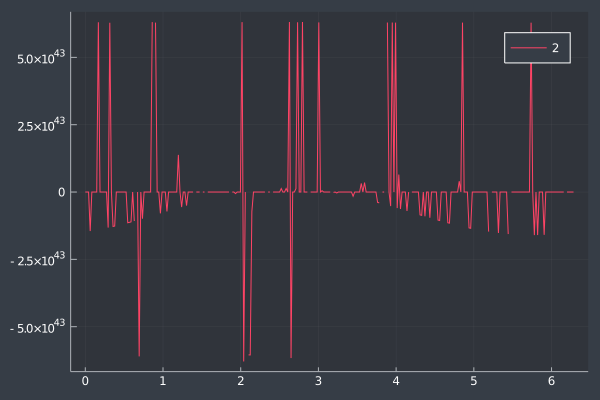

In [302]:
plot()
# plot(LinRange(0,2*pi,nk),b,label="1")
plot!(LinRange(0,2*pi,nk),a,label="2")
# plot!(LinRange(0,2*pi,nk),c,label="diff")

In [136]:
system_at_index(system_test1,pos_1).cl1-system_at_index(system,pos_1).cl1

3-element Array{Float64,1}:
 -0.2394999999999996
  2.1707
  0.23950000000000005

In [137]:
system_at_index(system_test2,pos_2).cl1-system_at_index(system,pos_2).cl1

3-element Array{Float64,1}:
 -0.2394999999999996
  2.1706999999999983
  0.2394999999999996

In [280]:
n=6;nk=100;
system=make_symstem(n);
dipole=[]
angle=LinRange(0, pi*4, nk)
for i in angle
    theta=i
    axis=[1,0,0.]
    system_test=copy(system)
    pos_1=[1,1,1]
    system_test[pos_1[1],pos_1[2],pos_1[3]]=
            rot_tetra_test_1(system_at_index(system,pos_1),axis,theta);
    dipole_tmp=get_dipole_energy(system_test,pos_1);
    push!(dipole,dipole_tmp)
    end;

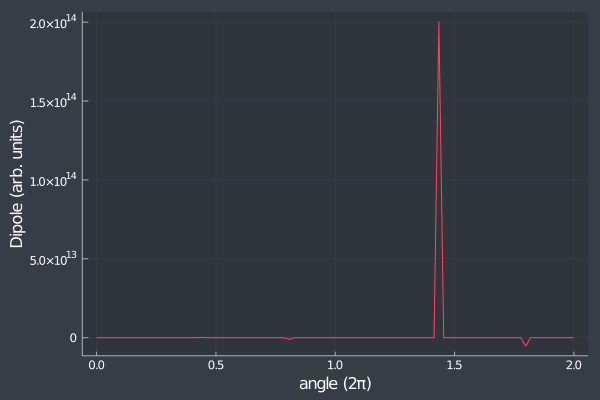

In [281]:
plot(angle/(2π),dipole,ylabel="Dipole (arb. units)",xlabel="angle (2π)",label="",linewidth=1)

In [21]:
struct tetra
    ge::Array{Float64,1}
    cl1::Array{Float64,1}
    cl2::Array{Float64,1}
    cl3::Array{Float64,1}
end


#check equavality of two struc 
function check_equal(t1::tetra,t2::tetra)
    if t1.ge==t2.ge && t1.cl1==t2.cl1  && t1.cl2==t2.cl2 && t1.cl3==t2.cl3
        return true
    else
        return false
        end;
    end;

#= Mat mul for rotation
=#
icross(b) = copy(Transpose(hcat([cross(Matrix(1.0I, 3, 3)[:,i],b) for i in 1:3]...)));
anchor(tetra) = (tetra.ge+tetra.cl1+tetra.cl2+tetra.cl3)/4

function Mdot(a1,a2)
    #=redefing dot product like numpy for matrix=#
    a1_1=copy(Transpose(a1))'
    return [dot(a1_1[i,:],a2) for i in 1:3]
end


function rot(coords,anc,axis,theta)
    #=rotate coords by theta wrt anc with axis as axis=#
    theta %= 2 * pi
    rm=exp(icross(axis/norm(axis))*theta)
    val=Mdot(rm,(coords-anc))+anc
    return val
    end;


#ROtating a tetra
function rot_tetra_test_1(t::tetra,axis::Array{Float64,1},theta)
    #=rotate all atoms in tetra by theta with axis = axis=#
    anc=anchor(t)
    ge=rot(t.ge,anc,axis,theta)
    cl1=rot(t.cl1,anc,axis,theta)
    cl2=rot(t.cl2,anc,axis,theta)
    cl3=rot(t.cl3,anc,axis,theta)
    return tetra(ge,cl1,cl2,cl3)
    end;

#---PBC index
function pbc_1(system,index)
    eval_1(i,n)= ((abs(i)-1) ÷ n)*((sign(i)+1) ÷ 2) - ((sign(i-1)-1) ÷ 2)*((i-n) ÷ n)
    index_1(i,n)=((abs(i+n-1) % n)+1)
    unit_size=size(system)[1]
    a=(-system[1,1,1].ge+system[1,1,2].ge)[3]*unit_size
    uc=eval_1.(index,unit_size)*a
    index_mod=index_1.(index,unit_size)#index .% (unit_size+1)
    return index_mod,uc
    end;

#----get the tetra of a system at given index with PBC
function system_at_index(system,index)
    index_mod,uc=pbc_1(system,index)
    tetra_tmp=system[index_mod[1],index_mod[2],index_mod[3]]
    ge=tetra_tmp.ge+uc
    cl1=tetra_tmp.cl1+uc
    cl2=tetra_tmp.cl2+uc
    cl3=tetra_tmp.cl3+uc
    return tetra(ge,cl1,cl2,cl3)
    end;




# NN algorithm
function get_nn_2(system,pos)
    tmp=Array{Float64, 1}[]
    for i in -1:1
        for j in -1:1
            for k in -1:1
                index_tmp=pos+[i,j,k]
                temp=system_at_index(system,index_tmp)
                push!(tmp,temp.cl1)
                push!(tmp,temp.cl2)
                push!(tmp,temp.cl3)
            end
        end
    end
    return tmp
end

# Mean and Var from NN
function get_mean_var(system,pos,return_type="var")
    # Get the mean or variance of a position of lattice  wrt bond distance#
    sys=system[pos[1],pos[2],pos[3]]
    distance_1=colwise(Euclidean(), sys.ge, copy(hcat(get_nn_2(system,pos)...)))
    nn=sort(distance_1)[1:6]
    var_sys=var(nn)
    mean_sys=mean(nn)
    if return_type=="mean"
        return mean_sys
    else
        return var_sys
    end
end

get_mean_var (generic function with 2 methods)

In [28]:
n=6;nk=100;
system=make_symstem(n);

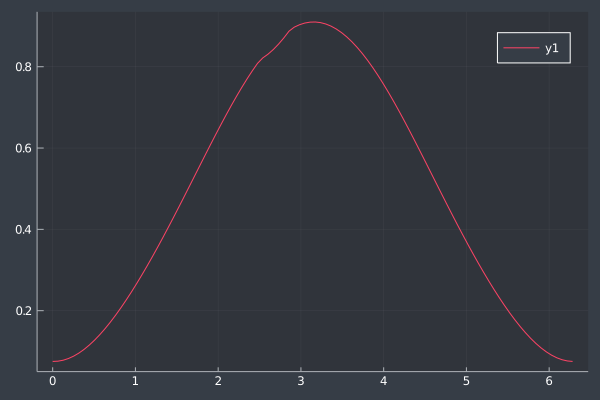

In [41]:
function e1(i)
    system1=copy(system)
    pos=[2,2,5]
    axis=[0,0,1.]
    theta=i
    system1[pos[1],pos[2],pos[3]]=rot_tetra_test_1(system[pos[1],pos[2],pos[3]],
    axis,theta)
    get_mean_var(system1,pos)
    end;
plot(e1,(LinRange(0,2*pi,100)))